## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
alpha = 1
eps = 4

# scale =
# 0 : the images are scaled to [0, 255]
# 1 : the images are scaled to [0, 1]
scale = 1

use_cuda = True

## 3. Prepare Data

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [7]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


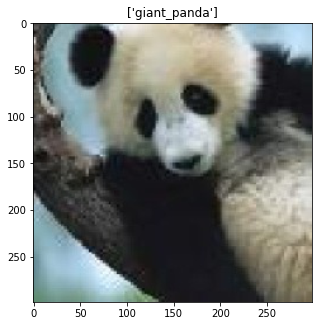

In [9]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [10]:
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


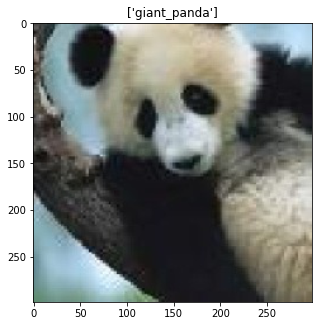

Accuracy of test text: 100.000000 %


In [12]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

### 1) Basic iterative_attack

In [13]:
# Also known as I-FGSM Attack
def basic_iterative_attack(model, loss, images, labels, scale, eps, alpha, iters=0) :
    images = images.to(device)
    labels = labels.to(device)
    clamp_max = 255
    
    if iters == 0 :
        # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
                
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
            
    return images

In [14]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


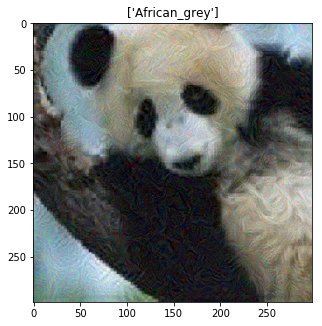

Accuracy of test text: 0.000000 %


In [15]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = basic_iterative_attack(model, loss, images, labels, scale, eps, alpha).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

### 2) Least likely class attack

In [16]:
# Warning : No label used
# It is abbreviation of iterative least likely class attack
def ll_class_attack(model, loss, images, scale, eps, alpha, iters=0) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 255
    
    if iters == 0 :
        # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images - alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
    
    return images

In [17]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


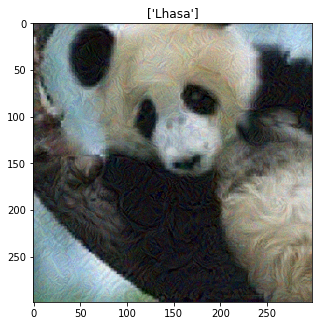

Accuracy of test text: 0.000000 %


In [18]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = ll_class_attack(model, loss, images, scale, eps, alpha).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 6. Attack with a photo of a adversarial image

After taking the picture above with Galaxy S7, and then rotated & cropped.

In [19]:
normal_data = image_folder_custom_label(root = './data/adversarial', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

Attack Image & Predicted Label


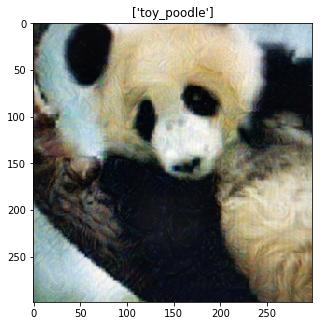

Accuracy of test text: 0.000000 %


In [20]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [21]:
print("Confidence with %.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())

Confidence with 29.83 %
